## One Cycle Scheduler vs TPU Scheduler

This notebook compares two different learning rate schedulers. The One Cycler Scheduler used in the fastai [module](https://docs.fast.ai/callbacks.one_cycle.html#Training-with-the-1cycle-policy) and the scheduler implemented in this [notebook](https://www.kaggle.com/mgornergoogle/five-flowers-with-keras-and-xception-on-tpu) for TPU (I decided to name it TPU Scheduler in this notebook). I compare both of them using the same settings in model and data settings.

The data augmentation techniques used in this notebook is taken from the following amazing notebooks.
1. [flower-with-tpus-advanced-augmentation](http://www.kaggle.com/dimitreoliveira/flower-with-tpus-advanced-augmentation)
2. [rotation-augmentation-gpu-tpu-0-96](https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96)
3. [make-chris-deotte-s-data-augmentation-faster](https://www.kaggle.com/yihdarshieh/make-chris-deotte-s-data-augmentation-faster)

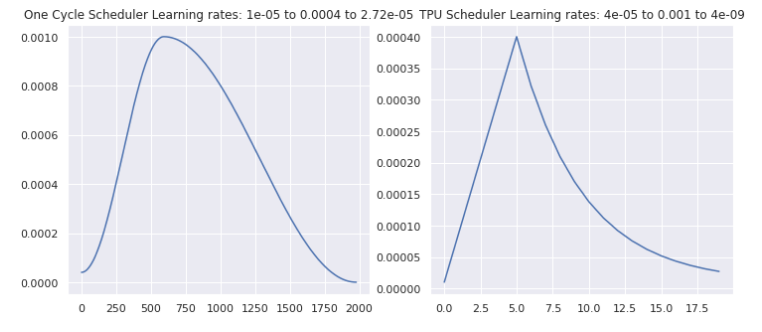

In [ ]:
import os
import re
import math
import warnings
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow as tf
import tensorflow.keras.backend as K
print(tf.__version__)

In [ ]:
def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
sns.set()
SEED = 17
seed_everything(SEED)
warnings.filterwarnings("ignore")

## Configurations

In [ ]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
HEIGHT, WIDTH = (512, 512)
CHANNELS = 3
N_CLASSES = 104

#Get datatset from google cloud services
GCS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started') + '/tfrecords-jpeg-%sx%s' % (HEIGHT, WIDTH)

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

CLASSES = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 
    'wild geranium', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 
    'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 
    'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 
    'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 
    'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 
    'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 
    'carnation', 'garden phlox', 'love in the mist', 'cosmos',  'alpine sea holly', 
    'ruby-lipped cattleya', 'cape flower', 'great masterwort',  'siam tulip', 
    'lenten rose', 'barberton daisy', 'daffodil',  'sword lily', 'poinsettia', 
    'bolero deep blue',  'wallflower', 'marigold', 'buttercup', 'daisy', 
    'common dandelion', 'petunia', 'wild pansy', 'primula',  'sunflower', 
    'lilac hibiscus', 'bishop of llandaff', 'gaura',  'geranium', 'orange dahlia', 
    'pink-yellow dahlia', 'cautleya spicata',  'japanese anemone', 'black-eyed susan', 
    'silverbush', 'californian poppy',  'osteospermum', 'spring crocus', 'iris', 
    'windflower',  'tree poppy', 'gazania', 'azalea', 'water lily',  'rose', 
    'thorn apple', 'morning glory', 'passion flower',  'lotus', 'toad lily', 
    'anthurium', 'frangipani',  'clematis', 'hibiscus', 'columbine', 'desert-rose', 
    'tree mallow', 'magnolia', 'cyclamen ', 'watercress',  'canna lily', 
    'hippeastrum ', 'bee balm', 'pink quill',  'foxglove', 'bougainvillea', 
    'camellia', 'mallow',  'mexican petunia',  'bromelia', 'blanket flower', 
    'trumpet creeper',  'blackberry lily', 'common tulip', 'wild rose']

## Helper and Augmentation functions

In [ ]:
def transform_rotation(image):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = HEIGHT
    XDIM = DIM%2 #fix for size 331
    
    rotation = 15. * tf.random.normal([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = HEIGHT
    XDIM = DIM%2 #fix for size 331
    
    shear = 5. * tf.random.normal([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = HEIGHT
    XDIM = DIM%2 #fix for size 331
    
    height_shift = 16. * tf.random.normal([1],dtype='float32') 
    width_shift = 16. * tf.random.normal([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_zoom(image):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly zoomed
    DIM = HEIGHT
    XDIM = DIM%2 #fix for size 331
    
    height_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    width_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(zoom_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

In [ ]:
# Datasets utility functions
AUTO = tf.data.experimental.AUTOTUNE # instructs the API to read from multiple files if available.

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=SEED)
    
    ### Spatial-level transforms
    if p_spatial >= .2:
        image = tf.image.random_flip_left_right(image, seed=SEED)
        image = tf.image.random_flip_up_down(image, seed=SEED)
        
    if p_crop >= .7:
        if p_crop >= .95:
            image = tf.image.random_crop(image, size=[int(HEIGHT*.6), int(WIDTH*.6), CHANNELS], seed=SEED)
        elif p_crop >= .85:
            image = tf.image.random_crop(image, size=[int(HEIGHT*.7), int(WIDTH*.7), CHANNELS], seed=SEED)
        elif p_crop >= .8:
            image = tf.image.random_crop(image, size=[int(HEIGHT*.8), int(WIDTH*.8), CHANNELS], seed=SEED)
        else:
            image = tf.image.random_crop(image, size=[int(HEIGHT*.9), int(WIDTH*.9), CHANNELS], seed=SEED)
        image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    if p_spatial2 >= .6:
        if p_spatial2 >= .9:
            image = transform_rotation(image)
        elif p_spatial2 >= .8:
            image = transform_zoom(image)
        elif p_spatial2 >= .7:
            image = transform_shift(image)
        else:
            image = transform_shear(image)
        
    ## Pixel-level transforms
    if p_pixel >= .4:
        if p_pixel >= .85:
            image = tf.image.random_saturation(image, lower=0, upper=2, seed=SEED)
        elif p_pixel >= .65:
            image = tf.image.random_contrast(image, lower=.8, upper=2, seed=SEED)
        elif p_pixel >= .5:
            image = tf.image.random_brightness(image, max_delta=.2, seed=SEED)
        else:
            image = tf.image.adjust_gamma(image, gamma=.6)

    return image, label

def get_training_dataset(do_aug=True):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_train_valid_datasets():
    dataset = load_dataset(TRAINING_FILENAMES + VALIDATION_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
# Visualization utility functions
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(15,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title(title)
    ax.set_ylabel(title.split(" ")[-1])
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
# Count train, val and test data
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Number of training images %d' % NUM_TRAINING_IMAGES)
print('Number of validation images %d' % NUM_VALIDATION_IMAGES)
print('Number of test images %d' % NUM_TEST_IMAGES)

## Augmentation Visualization

In [ ]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
all_elements = get_training_dataset().unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(data_augment).batch(25)

display_batch_of_images(next(iter(augmented_element)))

## Model function and schedulers callback

In [ ]:
def create_model(input_shape, N_CLASSES):
    
    base_model = tf.keras.applications.DenseNet201(
        weights='imagenet', include_top=False, input_shape=input_shape)
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax')
    ])
    
    return model

In [ ]:
# Used this implementation https://www.avanwyk.com/tensorflow-2-super-convergence-with-the-1cycle-policy/

from tensorflow.keras.callbacks import Callback

class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """ 
Callback that schedules the learning rate on a 1cycle policy as per Leslie Smith's 
paper(https://arxiv.org/pdf/1803.09820.pdf). If the model supports a momentum parameter, it will also be adapted by 
the schedule. The implementation adopts additional improvements as per the fastai 
library: https://docs.fast.ai/callbacks.one_cycle.html, where only two phases are used and the adaptation is done 
using cosine annealing. 

In phase 1 the LR increases from lr_max / div_factor to lr_max and momentum decreases from mom_max to mom_min.
In the second phase the LR decreases from lr_max to lr_max / (div_factor * 1e4) and momemtum from mom_max to mom_min.
By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter phase1_pct.
"""

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

In [ ]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

## Training configurations

In [ ]:
EPOCHS = 20
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

TRAIN_VALID = False

if TRAIN_VALID:
    STEPS_PER_EPOCH = (NUM_TRAINING_IMAGES + NUM_VALIDATION_IMAGES) // BATCH_SIZE
else:
    STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

LR = 1e-3
steps = STEPS_PER_EPOCH * EPOCHS

## Visualization of schedulers

In [ ]:
phase_1_pct=0.3
div_factor=25.
lr_max = LR

lr_min = lr_max / div_factor
final_lr = lr_max / (div_factor * 1e4)
phase_1_steps = int(steps * phase_1_pct)
phase_2_steps = int(steps - phase_1_steps)

phase1 = CosineAnnealer(lr_min, lr_max, phase_1_steps)
phase2 = CosineAnnealer(lr_max, final_lr, phase_2_steps)

lrs1 = []
for step in range(phase_1_steps):
    lrs1.append(phase1.step())
    
for step in range(phase_2_steps):
    lrs1.append(phase2.step())

rng1 = [i for i in range(phase_1_steps + phase_2_steps)]

rng2 = [i for i in range(EPOCHS)]
lrs2 = [lrfn(x) for x in rng2]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(rng1, lrs1)
axes[0].set_title("One Cycle Scheduler Learning rates: {:.3g} to {:.3g} to {:.3g}".format(lrs2[0], max(lrs2), lrs2[-1]))

axes[1].plot(rng2, lrs2)
axes[1].set_title("TPU Scheduler Learning rates: {:.3g} to {:.3g} to {:.3g}".format(lr_min, lr_max, final_lr));

In [ ]:
val_ds = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
val_images_ds = val_ds.map(lambda image, label: image)
val_labels_ds = val_ds.map(lambda image, label: label).unbatch()
val_correct_labels = next(iter(val_labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch

test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
test_images_ds = test_ds.map(lambda image, idnum: image)

In [ ]:
with strategy.scope():
    model = create_model((None, None, CHANNELS), N_CLASSES)

model.summary()

## One Cycle Scheduler experiment

In [ ]:
lr_schedule = OneCycleScheduler(LR, steps)

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

history1 = model.fit(x=get_training_dataset() if TRAIN_VALID == False else get_train_valid_datasets(),
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=get_validation_dataset() if TRAIN_VALID == False else None,
                    epochs=EPOCHS, callbacks=[lr_schedule],
                    verbose=1)

In [ ]:
val_probabilities = model.predict(val_images_ds)
val_predictions = np.argmax(val_probabilities, axis=-1)

score_sch1 = f1_score(val_correct_labels, val_predictions, labels=range(len(CLASSES)), average='macro')
precision_sch1 = precision_score(val_correct_labels, val_predictions, labels=range(len(CLASSES)), average='macro')
recall_sch1 = recall_score(val_correct_labels, val_predictions, labels=range(len(CLASSES)), average='macro')

test_probabilities1 = model.predict(test_images_ds)

print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score_sch1, precision_sch1, recall_sch1))

## TPU Scheduler experiment

In [ ]:
with strategy.scope():
    model = create_model((None, None, CHANNELS), N_CLASSES)

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

history2 = model.fit(x=get_training_dataset() if TRAIN_VALID == False else get_train_valid_datasets(),
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=get_validation_dataset() if TRAIN_VALID == False else None,
                    epochs=EPOCHS, callbacks=[lr_schedule],
                    verbose=1)

In [ ]:
val_probabilities = model.predict(val_images_ds)
val_predictions = np.argmax(val_probabilities, axis=-1)

score_sch2 = f1_score(val_correct_labels, val_predictions, labels=range(len(CLASSES)), average='macro')
precision_sch2 = precision_score(val_correct_labels, val_predictions, labels=range(len(CLASSES)), average='macro')
recall_sch2 = recall_score(val_correct_labels, val_predictions, labels=range(len(CLASSES)), average='macro')

test_probabilities2 = model.predict(test_images_ds)

print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score_sch2, precision_sch2, recall_sch2))

## Comparing each sheduler train/validation loss and accuracy

In [ ]:
if TRAIN_VALID == False:
    display_training_curves(history1.history['loss'], history1.history['val_loss'], 'One Cycle Scheduler loss', 221)
    display_training_curves(history2.history['loss'], history2.history['val_loss'], 'TPU Scheduler loss', 222)
    display_training_curves(history1.history['sparse_categorical_accuracy'], history1.history['val_sparse_categorical_accuracy'], 'One Cycle Scheduler accuracy', 223)
    display_training_curves(history2.history['sparse_categorical_accuracy'], history2.history['val_sparse_categorical_accuracy'], 'TPU Scheduler accuracy', 224)

else:
    display_training_curves(history1.history['loss'], history1.history['loss'], 'One Cycle Scheduler loss', 221)
    display_training_curves(history2.history['loss'], history2.history['loss'], 'TPU Scheduler loss', 222)
    display_training_curves(history1.history['sparse_categorical_accuracy'], history1.history['sparse_categorical_accuracy'], 'One Cycle Scheduler accuracy', 223)
    display_training_curves(history2.history['sparse_categorical_accuracy'], history2.history['sparse_categorical_accuracy'], 'TPU Scheduler accuracy', 224)

## Validation score comparison for each scheduler

In [ ]:
pd.DataFrame([[score_sch1, precision_sch1, recall_sch1], [score_sch2, precision_sch2, recall_sch2]], 
                columns=['Precision', 'Recall', 'F1 Score'], 
                index=['One Cycle Scheduler', 'TPU Scheduler'])

## Submitting a blend of both schedulers

In [ ]:
print('[INFO] Computing predictions...')

probabilities = (test_probabilities1 + test_probabilities2) / 2
predictions = np.argmax(probabilities, axis=-1)

print('[INFO] Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')